# Image Captioning using Show, Attend and Tell

## Some Util Functions

In [1]:
def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.

    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.

    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

## Imports 

In [2]:
from PIL import Image
import os
from tqdm import tqdm
!pip install sacrebleu
import sacrebleu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage
import matplotlib.cm as cm
import spacy
spacy_eng = spacy.load("en_core_web_sm")
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00


## Dataset Preparation

In [3]:
chosen_dataset = 'flickr8k'

if chosen_dataset == 'flickr8k':
    df = pd.read_csv('/kaggle/input/flickr8k/captions.txt')
    img_paths = '/kaggle/input/flickr8k/Images'
elif chosen_dataset == 'flickr30k':
    df = pd.read_csv('/kaggle/input/flickr30k/captions.txt')
    img_paths = '/kaggle/input/flickr30k/Images'
    df.dropna(inplace=True)
    
print(df.shape)
df.head()

(40455, 2)


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


### Creating the vocabulary

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

    # we can impplement this to return the length of the vocabulary
    def __len__(self):
        return len(self.itos)

    @staticmethod # this is a static method, which means it will be called on the class itself and won't need to access any instance data (no self)
    def tokenizer_eng(text):
        # mine: we could convert the text to lower case before tokenization
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    # this method will take a list of all the text examples (captions) and then builds the vocabulary
    def build_vocabulary(self, sentence_list):
        frequencies = {} # this will store the frequency of each word in the dataset, so that we decide whether to keep it or not
        idx = 4 # we start the index from 4, because 0,1,2,3 are already taken by the special tokens
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                frequencies[word] = frequencies.get(word, 0) + 1
                # add the word to the vocabulary if it ever reaches the frequency threshold (==)
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    # this function takes any text and calls stoi on each token in the text
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]

In [5]:
captions = df['caption']
# initialize the vocabulary object
vocab = Vocabulary(freq_threshold=5)
# build the vocabulary using the captions list
vocab.build_vocabulary(captions.tolist())

In [6]:
len(vocab)

2994

### Splitting the dataset into training and validation sets

In [7]:
images = df['image'].unique()

# shuffle the images
np.random.seed(0)
images = np.random.permutation(images)

In [8]:
if chosen_dataset == 'flickr8k':
    # split the images into training, validation and test sets
    train_images = images[:6091]
    val_images = images[6091:7091]
    test_images = images[7091:]
elif chosen_dataset == 'flickr30k':
    train_images = images[:28783]
    val_images = images[28783:30783]
    test_images = images[30783:]

len(train_images), len(val_images), len(test_images)

(6091, 1000, 1000)

In [9]:
# construct the dataframes
train_df = df[df['image'].isin(train_images)].reset_index(drop=True)
val_df = df[df['image'].isin(val_images)].reset_index(drop=True)
test_df = df[df['image'].isin(test_images)].reset_index(drop=True)

## Datasets

In [10]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_df, transform=None, mode = 'train'):
        # root_dir: the directory where the images are stored
        self.root_dir = root_dir
        # captions_df: the dataframe containing the image names and their captions
        self.df = captions_df
        self.image_names = self.df['image']
        self.captions = self.df['caption']
        self.transform = transform
        # the vocabulary object
        self.vocab = vocab
        self.mode = mode

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # get the image 
        img_name = self.image_names[idx]
        image = Image.open(os.path.join(self.root_dir, img_name)).convert("RGB")
        #plt.imshow(image)
        if self.transform:
            image = self.transform(image)

        # get the caption and numericalize it
        caption = self.captions[idx]
        # first we add the index of the <SOS> token 
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        # then we add the index of each token in the caption
        numericalized_caption += self.vocab.numericalize(caption)
        # finally we add the index of the <EOS> token
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        # we also return the length of the caption
        caption_length = len(numericalized_caption)

        # if the mode is train, return the image and the caption
        if self.mode == 'train':
            return image, torch.tensor(numericalized_caption) , caption_length
        # if the mode is val or test, return the image, the caption and all captions for that image
        else:
            all_captions = self.df[self.df['image'] == img_name]['caption'].tolist()
            all_captions = [[caption.lower()] for caption in all_captions]
            return image, torch.tensor(numericalized_caption), caption_length, all_captions
        
        
    def textualize(self, tensor):
        # convert a tensor of indices to the corresponding text if it is not a special token
        sentence = ""
        add_space = True
        for i in tensor:
            i = i.item()
            if i == self.vocab.stoi["<SOS>"] or i == self.vocab.stoi["<EOS>"] or i == self.vocab.stoi["<PAD>"] or i == self.vocab.stoi["<UNK>"]:
                continue
            # if the word is "-" we don't add a space before it or after it
            if self.vocab.itos[i] == "-":
                sentence += self.vocab.itos[i]
                add_space = False
            else:
                if add_space:
                    sentence += " " + self.vocab.itos[i]
                else:
                    sentence += self.vocab.itos[i]
                    add_space = True
        return sentence

In [11]:
transform = models.ResNet101_Weights.DEFAULT.transforms()


train_dataset = FlickrDataset(root_dir=img_paths, captions_df=train_df, transform=transform)
val_dataset = FlickrDataset(root_dir=img_paths, captions_df=val_df, transform=transform, mode='val')
test_dataset = FlickrDataset(root_dir=img_paths, captions_df=test_df, transform=transform, mode='test')

## Data Loaders

In [12]:
def collate_fn(batch, pad_idx):
    # batch is a list of all examples in the batch, in each example we have a tuple (img, caption) -from the dataset implementation-
    # pad_idx is the index of the <PAD> token in the vocabulary, which is basically the value we will use to pad the sequences
    images = [item[0].unsqueeze(0) for item in batch] # unsqueeze to add a dimension at the beginning of the tensor, so it will be (1, 3, 224, 224) instead of (3, 224, 224), this dimension will be used to concatenate the images
    images = torch.cat(images, dim=0) # concatenate the images along the first dimension    
    captions = [item[1] for item in batch] # we didn't unsqueeze here because pad_sequence will do that for us
    captions = pad_sequence(captions, batch_first=True, padding_value=pad_idx) # pad the sequences
    # caption lengths
    lengths = torch.LongTensor([item[2] for item in batch])


    if len(batch[0]) == 3:
        return images, captions.long(), lengths
    else:
        all_captions = [item[3] for item in batch]
        return images, captions.long(), lengths, all_captions
    
# data loaders
batch_size = 80
#pin_memory = torch.cuda.is_available()
pin_memory = False
torch.backends.cudnn.benchmark = True # this flag allows you to enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware.

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=pin_memory, collate_fn=lambda batch: collate_fn(batch, vocab.stoi["<PAD>"]))
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, shuffle=False, pin_memory=pin_memory, collate_fn=lambda batch: collate_fn(batch, vocab.stoi["<PAD>"]))
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False, pin_memory=pin_memory, collate_fn=lambda batch: collate_fn(batch, vocab.stoi["<PAD>"]))

## Models

In [13]:
class Encoder(nn.Module):
    def __init__(self, encoded_image_size=14,train_CNN=False):
        super(Encoder, self).__init__()
        # load the pretrained ResNet-101 model
        self.enc_image_size = encoded_image_size
        resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        #resnet = models.resnet101(pretrained=False)
        # remove the classification head (the last two layers)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # set the model trainability
        self.fine_tune(train_CNN)

        # adaptive pool layer to resize the images to fixed size (encoded_image_size x encoded_image_size) regardless of their original size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

       

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        """
        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune


    def forward(self, images):
        # Images are of shape (batch_size, 3, image_size, image_size)
        out = self.resnet(images) # (batch_size, 2048, out_image_size, out_image_size)
        out = self.adaptive_pool(out) # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1) # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out  

In [14]:
class Attention(nn.Module):
    def __init__(self, encoded_image_dim, hidden_size, attention_dim):
        super(Attention, self).__init__()
        # the linear layer to transform the encoded image 
        self.encoder_att = nn.Linear(encoded_image_dim, attention_dim)
        # the linear layer to transform the hidden state of the decoder
        self.decoder_att = nn.Linear(hidden_size, attention_dim)
        # the linear layer to calculate values to be used in the attention mechanism
        self.full_att = nn.Linear(attention_dim, 1)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # the attention scores should be calculated along the encoded image dimension

    def forward(self, image_embeddings,decoder_hidden):
        """
        :param image_embeddings: the encoded images from the encoder, shape: (batch_size, num_pixels, encoded_image_dim)
        :param decoder_hidden: the hidden state of the decoder (since we have a single LSTM cell, the hidden state is also the output), shape: (batch_size, hidden_size)
        """
        # project the encoded images
        att1 = self.encoder_att(image_embeddings) # (batch_size, num_pixels, attention_dim)
        # project the decoder hidden state
        att2 = self.decoder_att(decoder_hidden) # (batch_size, attention_dim)
        # add the two projections and apply the non-linearity
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2) # (batch_size, num_pixels)
        # calculate the attention weights
        alpha = self.softmax(att) # (batch_size, num_pixels)
        # calculate the context vector (the C vector is the multipliction of the attention scores and the image embeddings)
        context = (image_embeddings * alpha.unsqueeze(2)).sum(dim=1) # (batch_size, encoded_image_dim) (after multiplying the image encoding with the attention weights, we sum along the num_pixels dimension 
        return context, alpha
        

In [15]:
class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, word_embedding_dim, hidden_size, vocab_size, encoded_img_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of the attention network
        :param word_embedding_dim: size of the word embeddings
        :param hidden_size: size of the hidden state of the RNN
        :param vocab_size: size of the vocabulary
        :param encoded_img_dim: feature size of the encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()
        # the parameters
        self.encoded_img_dim = encoded_img_dim
        self.attention_dim = attention_dim
        self.word_embedding_dim = word_embedding_dim
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.dropout = dropout

        # attention network
        self.attention = Attention(encoded_img_dim, hidden_size, attention_dim)

        # embedding layer
        self.embedding = nn.Embedding(vocab_size, word_embedding_dim)
        # dropout layer
        self.dropout = nn.Dropout(p=self.dropout)
        # Decoder LSTM Cell
        self.decode_step = nn.LSTMCell(word_embedding_dim + encoded_img_dim, hidden_size, bias=True) # the LSTM cell
        ## 2 linear layers to transform the encoded image feature vector to the hidden state dimension of the LSTM cell
        self.init_h = nn.Linear(encoded_img_dim, hidden_size) # to initialize the hidden state of the LSTM cell
        self.init_c = nn.Linear(encoded_img_dim, hidden_size) # to initialize the cell state of the LSTM cell
        # linear layer to create a sigmoid-activated gate (used in attention mechanism)
        self.f_beta = nn.Linear(hidden_size, encoded_img_dim) # to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        # linear layer to find scores over the vocabular
        self.fc = nn.Linear(hidden_size, vocab_size) # to find scores over the vocabulary
        
        ## initialize some layers with the uniform distribution
        # the embedding layer
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        # the fc layer
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, image_embeddings):
        """
        :param image_embeddings: the encoded images from the encoder, of shape (batch_size, num_pixels = (enc_image_size * enc_image_size), encoded_img_dim)
        """
        mean_encoder_out = image_embeddings.mean(dim=1) # (batch_size, encoded_img_dim) this gets the average of all the pixels for each feature
        h = self.init_h(mean_encoder_out)  # (batch_size, hidden_size)
        c = self.init_c(mean_encoder_out)  # (batch_size, hidden_size)
        return h, c
    
    def forward(self, image_embeddings, captions, lengths):
        """
        :param image_embeddings: the encoded images from the encoder, of shape (batch_size, enc_image_size, enc_image_size, 2048 = encoded_img_dim)
        :param captions: the captions, of shape (batch_size, seq_length)
        :param lengths: the lengths of the captions, of shape (batch_size)
        """

        batch_size = image_embeddings.size(0)

        ## Flatten the image
        image_embeddings = image_embeddings.view(image_embeddings.size(0), -1, image_embeddings.size(-1)) # (batch_size, num_pixels = (enc_image_size * enc_image_size), encoded_img_dim)
        num_pixels = image_embeddings.size(1)

        ## sort the data by the length of the captions
        lengths, sorting_indices = lengths.sort(dim=0, descending=True) # this will return the lengths (sorted) and the indices that we will use to sort the rest
        image_embeddings = image_embeddings[sorting_indices]
        captions = captions[sorting_indices]


        ## get the word embeddings
        embeddings = self.embedding(captions) # (batch_size, seq_length, word_embedding_dim)

        ## initialize the hidden and cell states of the LSTM cell
        h, c = self.init_hidden_state(image_embeddings) # (batch_size, hidden_size)

        ## we wont process <EOS> token (why? because we don't need to predict anything after it)
        # so we will we will decrease the length of the captions by 1
        decode_lengths = (lengths - 1).tolist() # the decoding lengths will be the actual lengths - 1

        ## create tensors to hold the word prediction scores and alphas (attention weights)
        predictions = torch.zeros(batch_size, max(decode_lengths), self.vocab_size).to(device) # will store the scores (the probabilities) of each word in the vocabulary for each time step (not all of them but to the maximum decoding length) for each example 
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device) # will store the attention weights for each pixel in the image for each time step (not all of them but to the maximum decoding length) for each example
        
        ## start the decoding process
        for t in range(max(decode_lengths)):
            # get the batch size at that time step (the number of examples that still didn't reach the <EOS> token)
            batch_size_t = sum([l > t for l in decode_lengths])
            # get the attention weights and the context vector (which is the multilication of the attention weights and the image embeddings then summed along the num_pixels dimension) 
            # (we will send the image embeddings and the hidden state of the LSTM cell up to the current batch size)
            context, alpha = self.attention(image_embeddings[:batch_size_t], h[:batch_size_t]) # context is of shape (batch_size_t, encoded_img_dim) and alpha=attention weights is of shape (batch_size_t, num_pixels)
            # gate: to control the amount of information that will be passed to the LSTM cell (shape of the gate is the same as the context vector)
            gate = self.sigmoid(self.f_beta(h[:batch_size_t])) # (batch_size_t, encoded_img_dim)
            # apply the gate to the context
            context = gate * context
            # concatenate the embeddings and the context vector
            concat_input = torch.cat([embeddings[:batch_size_t, t, :], context], dim=1) # (batch_size_t, word_embedding_dim + encoded_img_dim)
            # pass the concatenated input to the LSTM cell
            h, c = self.decode_step(concat_input, (h[:batch_size_t], c[:batch_size_t])) # (batch_size_t, hidden_size)
            # pass the hidden state to the linear layer to get the scores
            preds = self.fc(self.dropout(h)) # (batch_size_t, vocab_size)
            # store the scores and the attention weights
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, captions, decode_lengths, alphas, sorting_indices 

## Initialization

In [16]:
## Model parameters
word_embedding_dim = 512
attention_dim = 512
hidden_size = 512
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training parameters
epochs = 120
epochs_since_improvement = 0
encoder_lr = 1e-4 # learning rate for encoder if fine-tuning
decoder_lr = 4e-4 # learning rate for decoder
grad_clip = 5. # clip gradients at an absolute value of 
alpha_c = 1. # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0. # BLEU-4 score right now
fine_tune_encoder = True # fine-tune encoder?



# model
decoder = DecoderWithAttention(attention_dim=attention_dim, word_embedding_dim=word_embedding_dim, hidden_size=hidden_size, vocab_size=len(vocab), dropout=dropout).to(device)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=decoder_lr)
encoder = Encoder(train_CNN=fine_tune_encoder).to(device)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=encoder_lr)

# scheduler 
# Define CosineAnnealingWarmRestarts scheduler
T_0 = 4  # number of epochs for the first restart
T_mult = 1  # no period length increase
eta_min = 1e-7  # minimum learning rate

use_scheduler = True
if use_scheduler:   
    decoder_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(decoder_optimizer, T_0=T_0, T_mult=T_mult, eta_min=eta_min,verbose=True)
    encoder_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(encoder_optimizer, T_0=T_0, T_mult=T_mult, eta_min=eta_min,verbose=True)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"]) # we will ignore the loss whenever the target is a <PAD> token

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 148MB/s]  


Epoch 00000: adjusting learning rate of group 0 to 4.0000e-04.
Epoch 00000: adjusting learning rate of group 0 to 1.0000e-04.


In [ ]:
# to load a model and resume training
load_model = False
if load_model:
    file_path = '/kaggle/input/show-attend-and-tell-model-flickr8k-19/checkpoint.pth.tar'
    checkpoint = torch.load(file_path)
    encoder.load_state_dict(checkpoint['encoder'])
    decoder.load_state_dict(checkpoint['decoder'])
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer'])
    decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer'])
    best_bleu4 = checkpoint['bleu-4']
    print(best_bleu4)

## Train

In [ ]:
for epoch in range(epochs):
    ## training phase 
    decoder.train()
    if fine_tune_encoder:
        encoder.train()

    # decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
    if epochs_since_improvement == 4:
        break
#     if epochs_since_improvement > 0 and epochs_since_improvement % 2 == 0:
#         adjust_learning_rate(decoder_optimizer, 0.9)
#         if fine_tune_encoder:
#             adjust_learning_rate(encoder_optimizer, 0.9)

    tk0 = tqdm(train_loader, total=len(train_loader), desc="Epoch {} Training".format(epoch+1))
    train_loss = 0
    train_examples = 0

    for i, (images, captions, lengths) in enumerate(tk0):
        # get the data to cuda if available
        images = images.to(device)
        captions = captions.to(device) 
        lengths = lengths.to(device)

        ## forward pass
        image_embeddings = encoder(images)
        logits, sorted_captions, decode_lengths, alphas, sorting_indices = decoder(image_embeddings, captions, lengths)

        # since we decoded starting with <SOS>, the predictions are all words after <SOS>, up to <EOS> (exclusive), so we need to adjust the targets also
        targets = sorted_captions[:, 1:]  # (batch_size, seq_length - <SOS>)


        ## Compute the cost and store it
        loss = criterion(logits.reshape(-1, logits.shape[2]), targets.reshape(-1)) # this reshapes the logits to be of shape (batch_size * seq_len, vocab_size) and the captions to be of shape (batch_size * seq_len) -we simply merged the batch_size and seq_len dimensions together for the criterion-
        train_loss += loss.item() * images.size(0)
        train_examples += images.size(0)

        # add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()



        ## Backward pass
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        ## clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        

        ## update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        ## update the progress bar
        tk0.set_postfix(loss=(train_loss / train_examples))

    ## validation phase
    decoder.eval()
    if fine_tune_encoder:
        encoder.eval()

    tk1 = tqdm(val_loader, total=len(val_loader), desc="Epoch {} Validation".format(epoch+1))
    val_loss = 0
    val_examples = 0
    bleu_score = 0

    
    with torch.no_grad():
        for i, (images, captions, lengths, all_captions) in enumerate(tk1):
            # get the data to cuda if available
            images = images.to(device)
            captions = captions.to(device)
            lengths = lengths.to(device)

            ## forward pass
            image_embeddings = encoder(images)
            logits, sorted_captions, decode_lengths, alphas, sorting_indices = decoder(image_embeddings, captions, lengths) 

            # since we decoded starting with <SOS>, the predictions are all words after <SOS>, up to <EOS> (exclusive), so we need to adjust the targets also
            targets = sorted_captions[:, 1:]

            ## Compute the cost and store it
            loss = criterion(logits.reshape(-1, logits.shape[2]), targets.reshape(-1))
            val_loss += loss.item() * images.size(0)
            val_examples += images.size(0)

            # add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            ## update the progress bar
            tk1.set_postfix(loss=(val_loss / val_examples))

            ## calculate the BLEU score
            # first, we need to sort the all_captions list based on the sorting_indices
            all_captions = [all_captions[j] for j in sorting_indices]
            # loop over the examples in the batch
            for j in range(logits.shape[0]):
                example = logits[j] # shape (seq_len, vocab_size)
                example = example.argmax(dim=1) # shape (seq_len)
                example = [val_dataset.textualize(example)]
                reference = all_captions[j]
                score = sacrebleu.corpus_bleu(example, reference)
                bleu_score += score.score


    avg_bleu_score = bleu_score / val_examples
    print(f"Epoch {epoch+1}, BLEU score: {avg_bleu_score}")
    if avg_bleu_score > best_bleu4:
        best_bleu4 = avg_bleu_score
        epochs_since_improvement = 0
        torch.save({
            'epoch': epoch,
            'encoder': encoder.state_dict(),
            'decoder': decoder.state_dict(),
            'encoder_optimizer': encoder_optimizer.state_dict(),
            'decoder_optimizer': decoder_optimizer.state_dict(),
            'bleu-4': best_bleu4
        }, 'checkpoint.pth.tar')
    else:
        epochs_since_improvement += 1

    if use_scheduler:  
        decoder_scheduler.step()
        if fine_tune_encoder:
            encoder_scheduler.step()



In [17]:
# Load the trained model 
file_path = '/kaggle/input/show-attend-and-tell-model-flickr8k-20/checkpoint.pth.tar'
checkpoint = torch.load(file_path)
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer'])
decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer'])
best_bleu4 = checkpoint['bleu-4']
print(best_bleu4)

19.51961930283746


## Evaluate The Bleu Score

In [ ]:
word_map = vocab.stoi
vocab_size = len(vocab)

# craete data loaders with batch_size = 1 (Necessary for evaluation)
validation_loader = DataLoader(val_dataset, batch_size=1,shuffle=False, collate_fn=lambda batch: collate_fn(batch, vocab.stoi["<PAD>"]))
testing_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda batch: collate_fn(batch, vocab.stoi["<PAD>"]))

def calculate_bleu4_score(encoder,decoder,beam_size,loader):
    """
    Evaluation

    :param beam_size: beam size at which to generate captions for evaluation
    :return: BLEU-4 score
    """
    decoder.eval()
    encoder.eval()
    total_images = len(loader)
    total_bleu_score = 0

    # For each image
    for i, (img, caps, caplens, allcaps) in enumerate(
            tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):

        k = beam_size

        # Move to GPU device, if available
        img = img.to(device)  # (1, 3, 256, 256)

        # Encode
        encoder_out = encoder(img)  # (1, enc_image_size, enc_image_size, encoder_dim)
        enc_image_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)

        # Flatten encoding
        encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # We'll treat the problem as having a batch size of k
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

        # Tensor to store top k previous words at each step; now they're just <start>
        k_prev_words = torch.LongTensor([[word_map['<SOS>']]] * k).to(device)  # (k, 1)

        # Tensor to store top k sequences; now they're just <start>
        seqs = k_prev_words  # (k, 1)

        # Tensor to store top k sequences' scores; now they're just 0
        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

        # Lists to store completed sequences and scores
        complete_seqs = list()
        complete_seqs_scores = list()

        # Start decoding
        step = 1
        h, c = decoder.init_hidden_state(encoder_out)

        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:

            embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

            awe, _ = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

            gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
            awe = gate * awe

            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

            scores = decoder.fc(h)  # (s, vocab_size)
            scores = F.log_softmax(scores, dim=1)

            # Add
            scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            # Convert unrolled indices to actual indices of scores
            prev_word_inds = top_k_words // vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)

            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)

            # Which sequences are incomplete (didn't reach <end>)?
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                               next_word != word_map['<EOS>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds)  # reduce beam length accordingly

            # Proceed with incomplete sequences
            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            # Break if things have been going on too long
            if step > 50:
                break
            step += 1
        if len(complete_seqs_scores) == 0:
            total_bleu_score += 0
            continue
        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i]
        example = val_dataset.textualize(torch.tensor(seq))
        caption = val_dataset.textualize(caps[0])
#         print(example)
#         print(caption)
#         print(allcaps[0])
        
        # Calculate BLEU-4 score using sacrebleu
        example_score = sacrebleu.corpus_bleu([example], allcaps[0]).score
        caption_score = sacrebleu.corpus_bleu([caption], allcaps[0]).score
        #print(example_score)
        #print(caption_score)
        if caption_score == 0:
            #print("0 caption")
            total_images -=1
            continue
        #score = (example_score / caption_score) * 100
        total_bleu_score += example_score

    encoder.train()
    decoder.train()
    
    avg_bleu_score = total_bleu_score / total_images
    return avg_bleu_score

calculate_bleu4_score(encoder,decoder,beam_size=3,loader=testing_loader)

## Caption The Image

In [19]:
image = '/kaggle/input/flickr8k/Images/1003163366_44323f5815.jpg'

 a man lays on a bench .


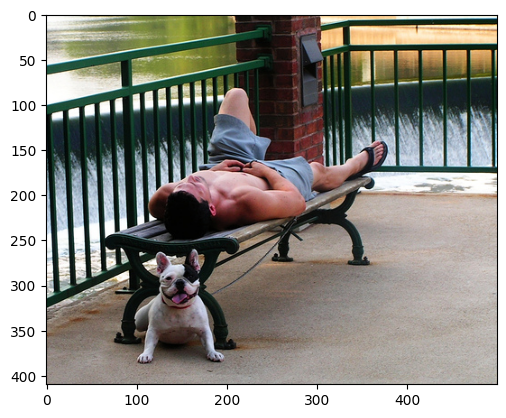

In [21]:
def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=10):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """
    encoder.eval()
    decoder.eval()
    k = beam_size
    vocab_size = len(word_map)

    # load the image
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    # transform the image
    image = transform(image).unsqueeze(0)
    # get the image to the device
    image = image.to(device)
    
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<SOS>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1) # shape: (s, vocab_size)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words // vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<EOS>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]
    # get the words
    caption = val_dataset.textualize(torch.tensor(seq))
    print(caption)
    alphas = torch.FloatTensor(alphas)

    encoder.train()
    decoder.train()
    return seq, alphas

seq, alphas = caption_image_beam_search(encoder,decoder,image,vocab.stoi)

## Visualize The Attention

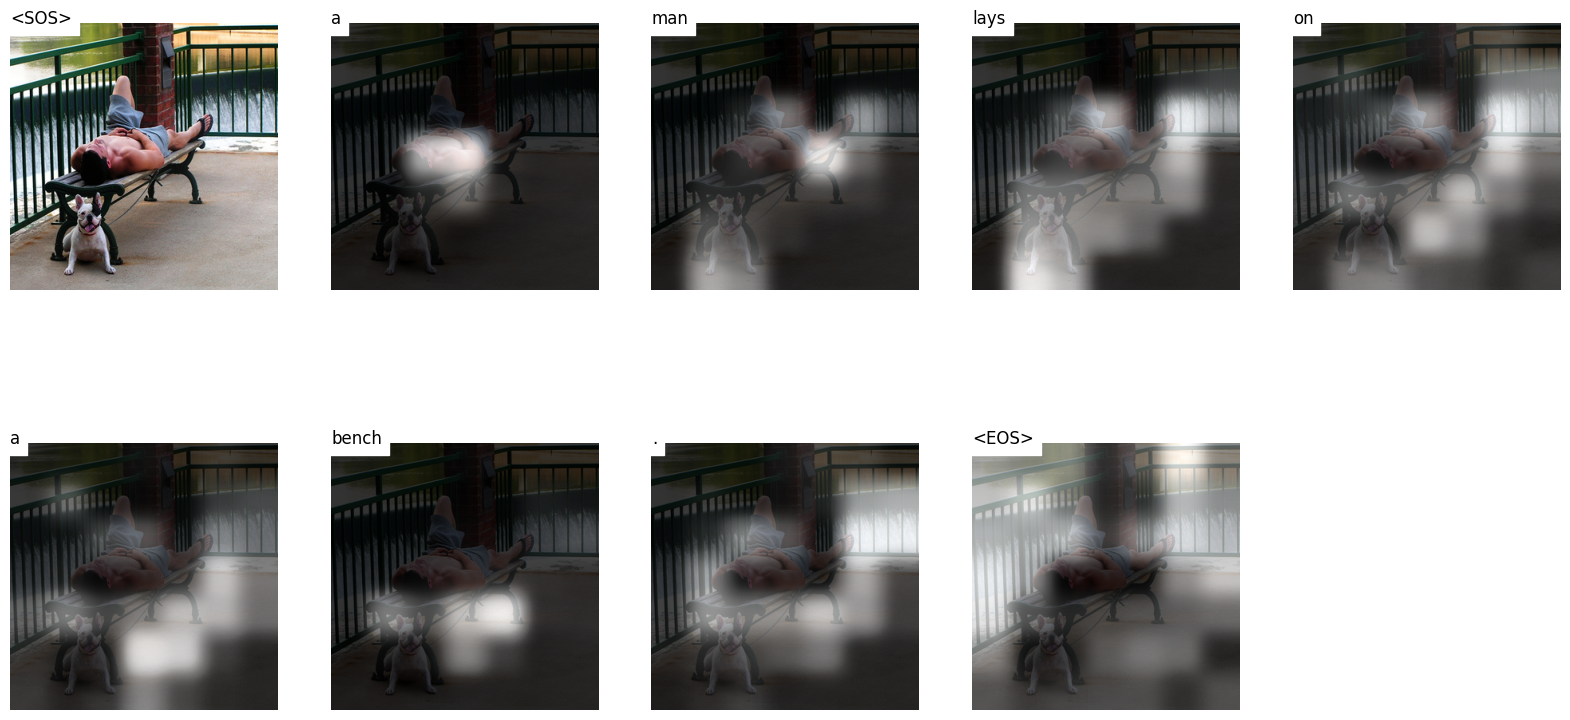

In [29]:
def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True, output_path=None):
    """
    Visualizes caption with weights at every word and optionally saves the plot.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    :param save_path: path to save the plot
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]
    # Adjust the figure size here
    plt.figure(figsize=(20, 10))  # You can change the width and height as needed
    
    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(int(np.ceil(len(words) / 5.)), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    
    if output_path:
        plt.savefig(os.path.join(output_path,image_path.split('/')[-1]), bbox_inches='tight')
    plt.show()

# Example usage
visualize_att(image, seq, alphas, vocab.itos, output_path='/kaggle/working/')